In [1]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from utils import data_processing
from utils.simulations import *
from execute import surv_hivae, surv_gan, surv_vae

import os
import json
import optuna

/opt/anaconda3/envs/hivae/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : omp.h header is not in the path, disabling OpenMP. To fix this, you can set the environment
                  variable OMP_PATH to the location of the header before importing keopscore or pykeops,
                  e.g. using os.environ: import os; os.environ['OMP_PATH'] = '/path/to/omp/header'
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


## Simulate the initial data

In [2]:
n_samples = 600
n_features_bytype = 6
n_active_features = 3 
treatment_effect = 0.
p_treated = 0.5
shape_T = 2.
shape_C = 2.
scale_C = 2.5
scale_C_indep = 3.9
feature_types_list = ["real", "cat"]
independent = True
data_types_create = True

control, treated, types = simulation(treatment_effect, n_samples, independent, feature_types_list,
                                         n_features_bytype, n_active_features, p_treated, shape_T,
                                         shape_C, scale_C, scale_C_indep, data_types_create, seed=0)

control = control.drop(columns='treatment')
treated = treated.drop(columns='treatment')

In [3]:
# control.head()

In [4]:
print("percent of uncensored data in control set {:.3f} and in treated set {:.3f}".format(np.mean(control['censor']), 
                                                                                          np.mean(treated['censor'])))

percent of uncensored data in control set 0.840 and in treated set 0.843


## Save data

In [5]:
dataset_name = "Simulations_5_indep"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
miss_file = "dataset/" + dataset_name + "/Missing.csv"
true_miss_file = None

control.to_csv(data_file_control, index=False, header=False)
types.to_csv(feat_types_file_control)
treated.to_csv(data_file_treated, index=False, header=False)
types.to_csv(feat_types_file_treated)

## Load data

In [6]:
# Load and transform control data
df_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, feat_types_file_control, miss_file, true_miss_file)
data_init_control_encoded = torch.from_numpy(df_init_control_encoded.values)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
df_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, miss_file, true_miss_file)
data_init_treated_encoded = torch.from_numpy(df_init_treated_encoded.values)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [7]:
fnames = types['name'][:-1].tolist()
fnames.append("time")#.append("censor")
fnames.append("censor")

In [8]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)

# Update dataframe
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

### Hyperparameters optimization

In [9]:
# Parameters of the optuna study

metric_optuna = "survival_km_distance" # metric to optimize in optuna
n_splits = 5 # number of splits for cross-validation
n_generated_dataset = 50 # number of generated datasets per fold to compute the metric
name_config = "simu_N{}_nfeat{}_t{}".format(n_samples, n_features_bytype, int(treatment_effect))

### Load best params and optuna study

In [10]:
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
generators_dict = {"HI-VAE_weibull" : surv_hivae,
                   "HI-VAE_piecewise" : surv_hivae,
                   "Surv-GAN" : surv_gan,
                   "Surv-VAE" : surv_vae}

original_dir = os.getcwd()

best_params_dict_survkm, study_dict_survkm = {}, {}
for generator_name in generators_sel:
    n_trials = 150
    study_name_cluster = "/home/pchassat/HI-VAE_Pytorch/dataset/" + dataset_name + "/optuna_results/optuna_study_{}_ntrials{}_{}_{}".format(name_config, n_trials, metric_optuna, generator_name)
    study_name = "dataset/" + dataset_name + "/optuna_results/optuna_study_{}_ntrials{}_{}_{}".format(name_config, n_trials, metric_optuna, generator_name)
    best_params_file = "dataset/" + dataset_name + "/optuna_results/best_params_{}_ntrials{}_{}_{}.json".format(name_config, n_trials, metric_optuna, generator_name)
    db_file = study_name + ".db"
    if os.path.exists(db_file):
        print("This optuna study already exists. Please change the name of the study or remove the file to create a new one.")
        study = optuna.load_study(study_name=study_name_cluster, storage="sqlite:///{}".format(db_file))
        study_dict_survkm[generator_name] = study
        with open(best_params_file, "r") as f:
            best_params_dict_survkm[generator_name] = json.load(f)
    else:
        raise FileNotFoundError("The optuna study does not exist. Please create it first.")
    

This optuna study already exists. Please change the name of the study or remove the file to create a new one.
This optuna study already exists. Please change the name of the study or remove the file to create a new one.
This optuna study already exists. Please change the name of the study or remove the file to create a new one.
This optuna study already exists. Please change the name of the study or remove the file to create a new one.


In [11]:
print("Best parameters for HI-VAE Weibull:")
print(" - with survival_km_distance: {}".format(best_params_dict_survkm["HI-VAE_weibull"]))
print('\n')
print("Best parameters for HI-VAE Piecewise:")
print(" - with survival_km_distance: {}".format(best_params_dict_survkm["HI-VAE_piecewise"]))
print('\n')
print("Best parameters for Surv-GAN:")
print(" - with survival_km_distance: {}".format(best_params_dict_survkm["Surv-GAN"]))
print('\n')
print("Best parameters for Surv-VAE:")
print(" - with survival_km_distance: {}".format(best_params_dict_survkm["Surv-VAE"]))

Best parameters for HI-VAE Weibull:
 - with survival_km_distance: {'lr': 0.001, 'batch_size': 180, 'z_dim': 25, 'y_dim': 175, 's_dim': 200}


Best parameters for HI-VAE Piecewise:
 - with survival_km_distance: {'lr': 0.001, 'batch_size': 180, 'z_dim': 90, 'y_dim': 85, 's_dim': 70, 'n_layers_surv_piecewise': 1, 'n_intervals': 15}


Best parameters for Surv-GAN:
 - with survival_km_distance: {'generator_n_layers_hidden': 2, 'generator_n_units_hidden': 150, 'generator_nonlin': 'leaky_relu', 'generator_dropout': 0.19697492628909993, 'discriminator_n_layers_hidden': 4, 'discriminator_n_units_hidden': 100, 'discriminator_nonlin': 'relu', 'discriminator_dropout': 0.09853466874748673, 'lr': 0.001, 'weight_decay': 0.0001, 'encoder_max_clusters': 18}


Best parameters for Surv-VAE:
 - with survival_km_distance: {'n_iter': 100, 'lr': 0.0001, 'decoder_n_layers_hidden': 1, 'weight_decay': 0.0001, 'batch_size': 512, 'n_units_embedding': 500, 'decoder_n_units_hidden': 300, 'decoder_nonlin': 'leaky_re

In [12]:
# Visualize the results of the optuna study

from optuna.visualization import plot_slice
from optuna.visualization import plot_optimization_history

print('---------------------- HI-VAE_weibull ----------------------')
fig = plot_slice(study_dict_survkm["HI-VAE_weibull"])
fig.show()

fig = plot_optimization_history(study_dict_survkm["HI-VAE_weibull"])
fig.show()

---------------------- HI-VAE_weibull ----------------------


In [13]:
print(study_dict_survkm["HI-VAE_weibull"].trials[0].params)

{'lr': 0.001, 'batch_size': 100, 'z_dim': 20, 'y_dim': 15, 's_dim': 20}


In [14]:

print('---------------------- HI-VAE_piecewise ----------------------')
fig = plot_slice(study_dict_survkm["HI-VAE_piecewise"])
fig.show()

fig = plot_optimization_history(study_dict_survkm["HI-VAE_piecewise"])
fig.show()

---------------------- HI-VAE_piecewise ----------------------


In [15]:
print(study_dict_survkm["HI-VAE_piecewise"].trials[0].params)

{'lr': 0.001, 'batch_size': 100, 'z_dim': 20, 'y_dim': 15, 's_dim': 20, 'n_layers_surv_piecewise': 1, 'n_intervals': 10}


In [16]:
print('---------------------- Surv-GAN ----------------------')
fig = plot_slice(study_dict_survkm["Surv-GAN"])
fig.show()

fig = plot_optimization_history(study_dict_survkm["Surv-GAN"])
fig.show()

---------------------- Surv-GAN ----------------------


In [17]:
print('---------------------- Surv-VAE ----------------------')
fig = plot_slice(study_dict_survkm["Surv-VAE"])
fig.show()

fig = plot_optimization_history(study_dict_survkm["Surv-VAE"])
fig.show()

---------------------- Surv-VAE ----------------------


In [18]:
# from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_parallel_coordinate, plot_contour

# # Visualize the optimization history
# plot_optimization_history(study_dict_survkm["HI-VAE_weibull"]).show()
# plot_param_importances(study_dict_survkm["HI-VAE_weibull"]).show()
# plot_slice(study_dict_survkm["HI-VAE_weibull"]).show()
# plot_parallel_coordinate(study_dict_survkm["HI-VAE_weibull"]).show()
# plot_contour(study_dict_survkm["HI-VAE_weibull"]).show()

## 2. Training and generation from the generative model

Possible generative models: HI-VAE (our), survival_gan, survival_ctgan, survival_nflow, survae (synthcity)

### Run with defaut_params

In [ ]:
# the datasets used for training is data_init_control
n_generated_dataset = 100
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
# generators_sel = ["Surv-GAN", "Surv-VAE"]
data_gen_control_dict = {}
for generator_name in generators_sel:
    print("=" * 100)
    print("Generate data by " + generator_name)
    if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise"]:
        feat_types_dict_ext = feat_types_dict.copy()
        for i in range(len(feat_types_dict)):
            if feat_types_dict_ext[i]['name'] == "survcens":
                if generator_name in["HI-VAE_weibull"]:
                    feat_types_dict_ext[i]["type"] = 'surv_weibull'
                else:
                    feat_types_dict_ext[i]["type"] = 'surv_piecewise'
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run(df_init_control_encoded, miss_mask_control, true_miss_mask_control, feat_types_dict_ext, n_generated_dataset, epochs=10000)
    else:
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run(data_init_control, columns=fnames, target_column="censor", time_to_event_column="time", n_generated_dataset=n_generated_dataset)

Generate data by HI-VAE_weibull
Epoch: [ 0]  time: 0.0850, ELBO_train: -15.32467222, KL_z: 1.72837490, KL_s: 0.07078397, reconstruction loss: -13.52551335
Epoch: [100]  time: 1.3713, ELBO_train: -12.05270767, KL_z: 0.82128075, KL_s: 0.04007471, reconstruction loss: -11.19135222
Epoch: [200]  time: 3.0122, ELBO_train: -11.98012733, KL_z: 1.11522096, KL_s: 0.03226030, reconstruction loss: -10.83264607
Epoch: [300]  time: 4.4402, ELBO_train: -11.85344744, KL_z: 1.27773511, KL_s: 0.03136051, reconstruction loss: -10.54435182
Epoch: [400]  time: 5.6583, ELBO_train: -11.56897306, KL_z: 1.36914766, KL_s: 0.03276956, reconstruction loss: -10.16705585
Epoch: [500]  time: 6.9383, ELBO_train: -11.70520449, KL_z: 1.54674077, KL_s: 0.04216969, reconstruction loss: -10.11629403
Epoch: [600]  time: 8.2805, ELBO_train: -11.51248837, KL_z: 1.62565464, KL_s: 0.04162204, reconstruction loss: -9.84521168
Epoch: [700]  time: 9.6676, ELBO_train: -11.52663374, KL_z: 1.68022931, KL_s: 0.04063630, reconstructi

### Run with best params surv_km_dist

In [ ]:
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
data_gen_control_dict_best_params_survkm = {}
for generator_name in generators_sel:
    print("=" * 100)
    print("Generate data by " + generator_name)
    best_params = best_params_dict_survkm[generator_name]
    if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise"]:
        feat_types_dict_ext = feat_types_dict.copy()
        for i in range(len(feat_types_dict)):
            if feat_types_dict_ext[i]['name'] == "survcens":
                if generator_name in["HI-VAE_weibull"]:
                    feat_types_dict_ext[i]["type"] = 'surv_weibull'
                else:
                    feat_types_dict_ext[i]["type"] = 'surv_piecewise'
        data_gen_control_dict_best_params_survkm[generator_name] = generators_dict[generator_name].run(df_init_control_encoded,
                                                                                                miss_mask_control,
                                                                                                true_miss_mask_control, 
                                                                                                feat_types_dict_ext, 
                                                                                                n_generated_dataset, 
                                                                                                params=best_params, 
                                                                                                epochs = 10000)
    else:
        data_gen_control_dict_best_params_survkm[generator_name] = generators_dict[generator_name].run(data_init_control, 
                                                                                                columns=fnames, 
                                                                                                target_column="censor", 
                                                                                                time_to_event_column="time", 
                                                                                                n_generated_dataset=n_generated_dataset, 
                                                                                                params=best_params)

Generate data by HI-VAE_weibull
Epoch: [ 0]  time: 0.0258, ELBO_train: -13.64323616, KL_z: 0.35523915, KL_s: 0.10261154, reconstruction loss: -13.18538547
Epoch: [100]  time: 1.7702, ELBO_train: -12.16580582, KL_z: 0.91927826, KL_s: 0.02504873, reconstruction loss: -11.22147882
Epoch: [200]  time: 3.4888, ELBO_train: -11.81649303, KL_z: 1.27100086, KL_s: 0.01106024, reconstruction loss: -10.53443193
Epoch: [300]  time: 5.2697, ELBO_train: -11.91312218, KL_z: 1.39260209, KL_s: 0.00834751, reconstruction loss: -10.51217258
Epoch: [400]  time: 6.8997, ELBO_train: -11.46296692, KL_z: 1.53219855, KL_s: 0.00753784, reconstruction loss: -9.92323053
Epoch: [500]  time: 8.5458, ELBO_train: -11.44977760, KL_z: 1.74448144, KL_s: 0.00759745, reconstruction loss: -9.69769871
Epoch: [600]  time: 10.2272, ELBO_train: -11.30016136, KL_z: 1.81180441, KL_s: 0.00769091, reconstruction loss: -9.48066604
Epoch: [700]  time: 11.8869, ELBO_train: -11.35713768, KL_z: 1.89897466, KL_s: 0.00752306, reconstructi

[2025-06-25T17:33:56.063781+0200][31971][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T17:33:56.065038+0200][31971][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-25T17:33:56.065697+0200][31971][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-25T17:33:56.066204+0200][31971][CRITICAL] module plugin_decaf load failed
[2025-06-25T17:33:56.145027+0200][31971][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T17:33:56.145895+0200][31971][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-25T17:33:56.146241+0200][31971][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-25T17:33:56.146527+0200]

Epoch: [1200]  time: 15.3286, ELBO_train: -11.40618038, KL_z: 1.80089724, KL_s: 0.02058935, reconstruction loss: -9.58469379
Early stopping at epoch 1200.
Training finished.
Generate data by Surv-GAN


  4%|▍         | 449/10000 [00:10<03:50, 41.44it/s]
[2025-06-25T17:34:16.599820+0200][31971][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T17:34:16.600567+0200][31971][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-25T17:34:16.600870+0200][31971][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-25T17:34:16.601170+0200][31971][CRITICAL] module plugin_decaf load failed
[2025-06-25T17:34:16.621410+0200][31971][CRITICAL] module disabled: /opt/anaconda3/envs/hivae/lib/python3.13/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-25T17:34:16.621915+0200][31971][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-06-25T17:34:16.622261+0200][31971][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no 

Generate data by Surv-VAE


100%|██████████| 100/100 [00:01<00:00, 85.58it/s]


### Plot survival curves

KeyError: 'HI-VAE_weibull'

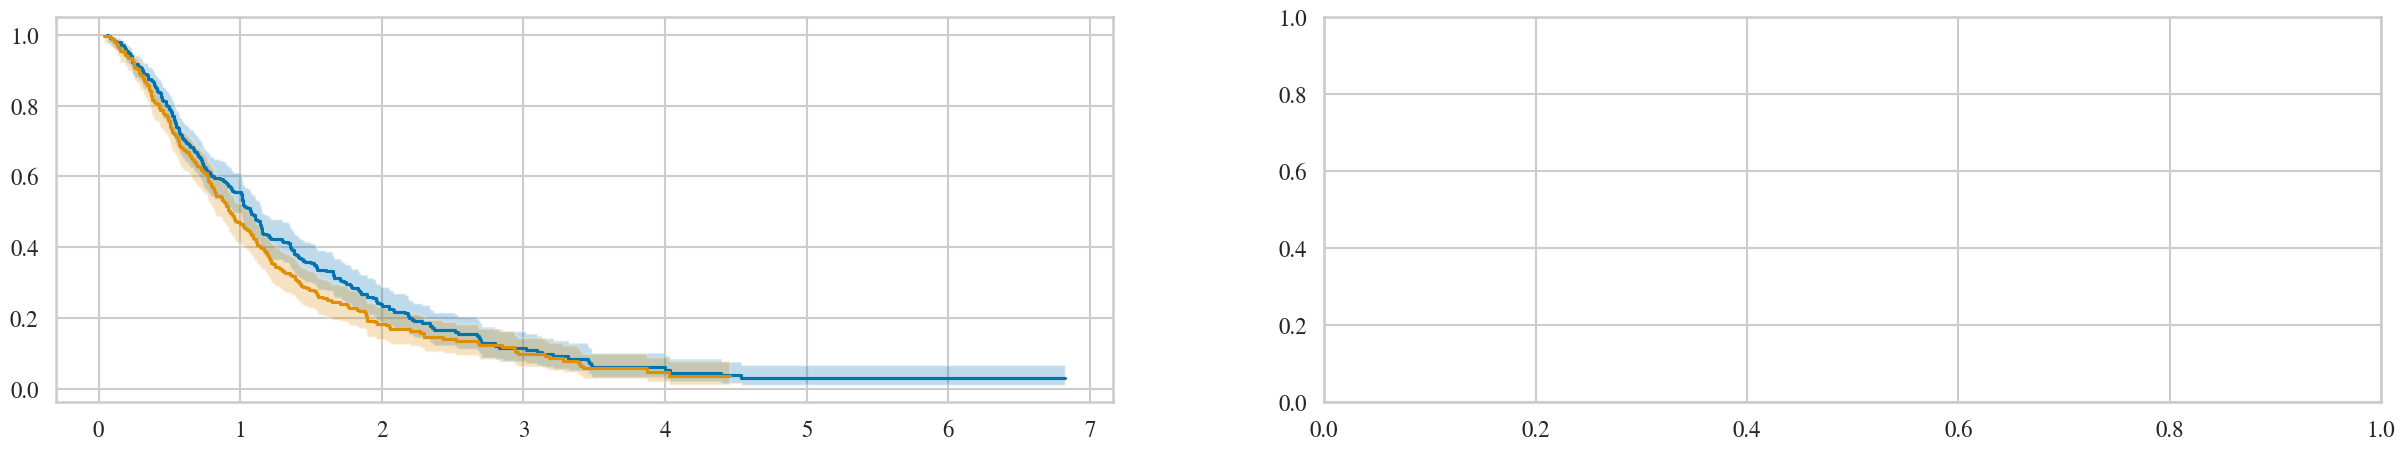

In [22]:
from sksurv.nonparametric import kaplan_meier_estimator

def kaplan_meier_estimation(surv_data, label=None, ax=None):
    surv_time  = surv_data['time'].values
    surv_ind = surv_data['censor'].values.astype(bool)
    uniq_time, surv_prob, conf_int = kaplan_meier_estimator(surv_ind, surv_time, conf_type="log-log")

    ax.step(uniq_time, surv_prob, where="post", label=label)
    ax.fill_between(uniq_time, conf_int[0], conf_int[1], alpha=0.25, step="post")

fig, axs = plt.subplots(1, 2, figsize=(30, 5))

kaplan_meier_estimation(control, label="Initial Control Group", ax=axs[0])
kaplan_meier_estimation(treated, label="Treatment Group", ax=axs[0])
sel_dataset_idx = 4
for i, generator_name in enumerate(generators_sel):
    df_syn_sel = pd.DataFrame(data_gen_control_dict[generator_name][sel_dataset_idx].numpy(), columns=fnames)
    kaplan_meier_estimation(df_syn_sel, label="Generated Control Group " + generator_name, ax=axs[0])
axs[0].set_ylim(0, 1)
axs[0].legend(fontsize=15)
axs[0].set_xlabel("Time", fontweight="semibold")
axs[0].set_ylabel("Survival Probability", fontweight="semibold")
axs[0].set_title("Survival Curves with Confidence Intervals with default setting", fontweight="bold")


kaplan_meier_estimation(control, label="Initial Control Group", ax=axs[1])
kaplan_meier_estimation(treated, label="Treatment Group", ax=axs[1])
for i, generator_name in enumerate(generators_sel):
    df_syn_sel = pd.DataFrame(data_gen_control_dict_best_params_survkm[generator_name][sel_dataset_idx].numpy(), columns=fnames)
    kaplan_meier_estimation(df_syn_sel, label="Generated Control Group " + generator_name, ax=axs[1])
axs[1].set_ylim(0, 1)
axs[1].legend(fontsize=15)
axs[1].set_xlabel("Time", fontweight="semibold")
axs[1].set_ylabel("Survival Probability", fontweight="semibold")
axs[1].set_title("Survival Curves with Confidence Intervals with best params survkm", fontweight="bold")

plt.show()

In [ ]:
# Convert generated data into dataframe
df_gen_control_dict_best_params_survkm = {}
df_gen_control_dict_default = {}
df_syn_dict_best_params_survkm = {}
df_syn_dict_default = {}
for generator_name in generators_sel:
    list_df_gen_control_best_params_survkm = []
    list_df_gen_control_default = []
    data_syn_best_params_survkm = []
    data_syn_default = []
    for j in range(n_generated_dataset):
        df_gen_survkm_control_j = pd.DataFrame(data_gen_control_dict_best_params_survkm[generator_name][j].numpy(), columns=fnames)
        df_gen_survkm_control_j['treatment'] = 0
        list_df_gen_control_best_params_survkm.append(df_gen_survkm_control_j)
        data_syn_best_params_survkm.append(pd.concat([df_init_treated, df_gen_survkm_control_j], ignore_index=True))

        df_gen_control_j = pd.DataFrame(data_gen_control_dict[generator_name][j].numpy(), columns=fnames)
        df_gen_control_j['treatment'] = 0
        list_df_gen_control_default.append(df_gen_control_j)
        data_syn_default.append(pd.concat([df_init_treated, df_gen_control_j], ignore_index=True))
        
    df_gen_control_dict_best_params_survkm[generator_name] = list_df_gen_control_best_params_survkm
    df_gen_control_dict_default[generator_name] = list_df_gen_control_default
    df_syn_dict_best_params_survkm[generator_name] = data_syn_best_params_survkm
    df_syn_dict_default[generator_name] = data_syn_default

### 3. Compare generation performance

#### 3.1. General metrics

In [ ]:
from utils.metrics import general_metrics
general_scores_survkm = []
general_scores_default = []
for generator_name in generators_sel:
    general_scores_survkm.append(general_metrics(df_init_control, df_gen_control_dict_best_params_survkm[generator_name], generator_name))
    general_scores_default.append(general_metrics(df_init_control, df_gen_control_dict_default[generator_name], generator_name))
general_scores_default_df = pd.concat(general_scores_default)
general_scores_survkm_df = pd.concat(general_scores_survkm)

##### 3.1.1. Data resemblance

===================== General performance with best params survkm: =====================


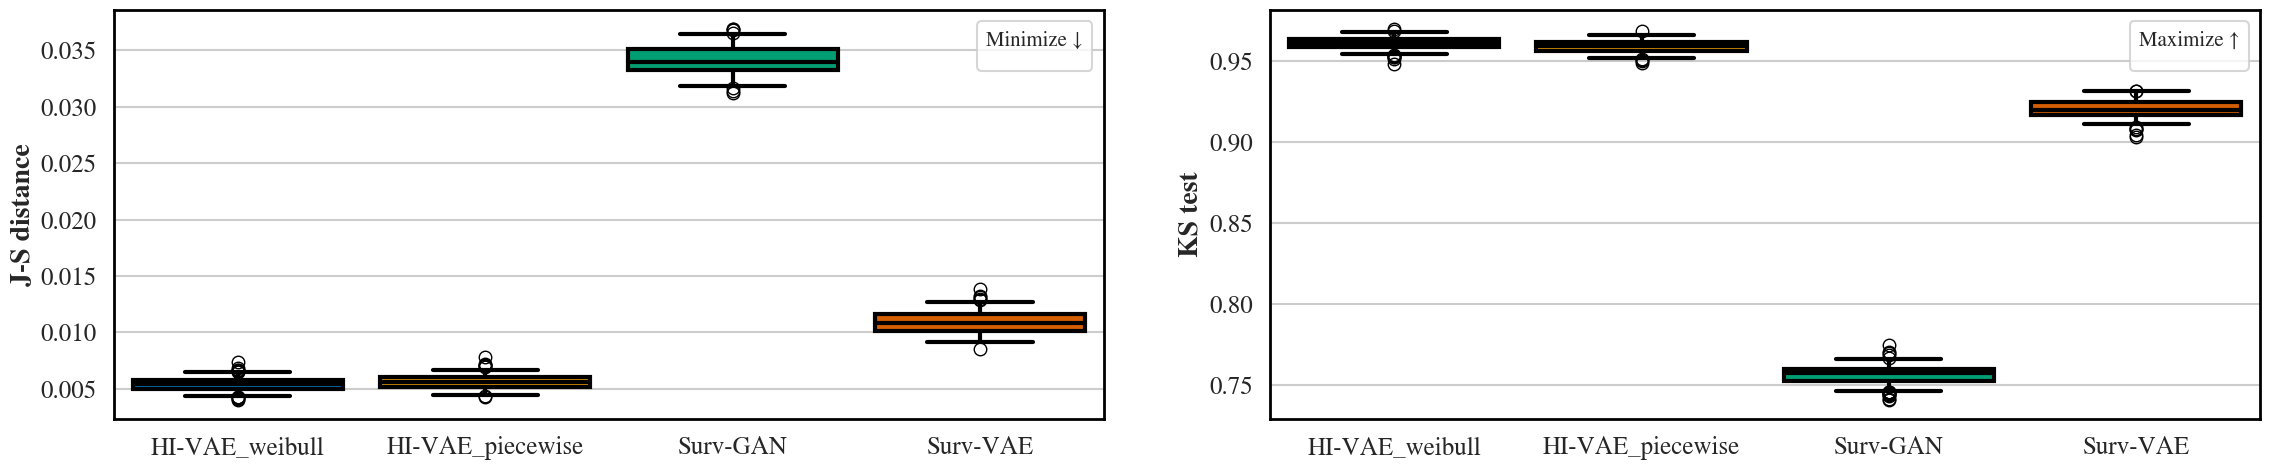

===================== General performance with default params: =====================


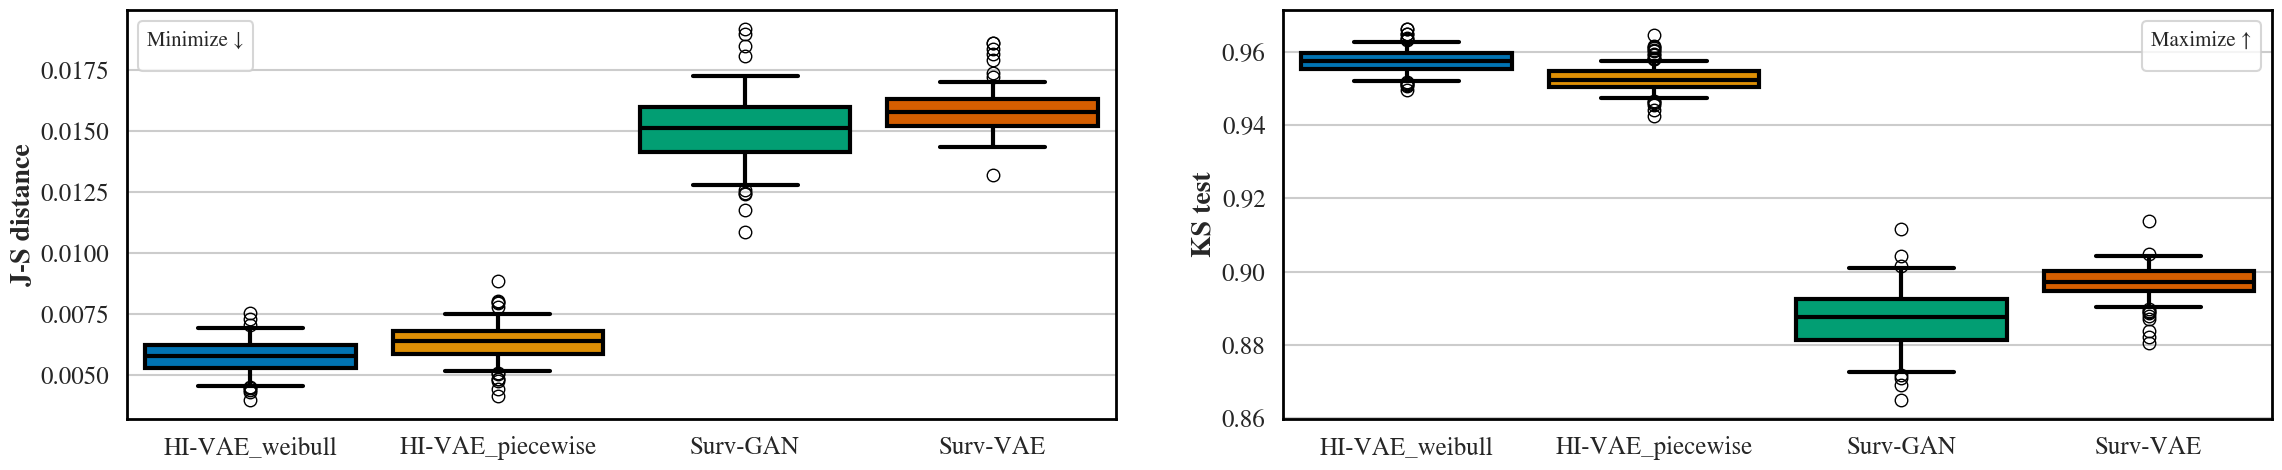

In [27]:
from utils.visualization import visualize_general_perf
print("===================== General performance with best params survkm: =====================")
visualize_general_perf(general_scores_survkm_df, metrics=[['J-S distance', "min"], ['KS test', "max"]])

print("===================== General performance with default params: =====================")
visualize_general_perf(general_scores_default_df, metrics=[['J-S distance', "min"], ['KS test', "max"]])

##### 3.1.2. Utility

===================== General performance with best params survkm: =====================


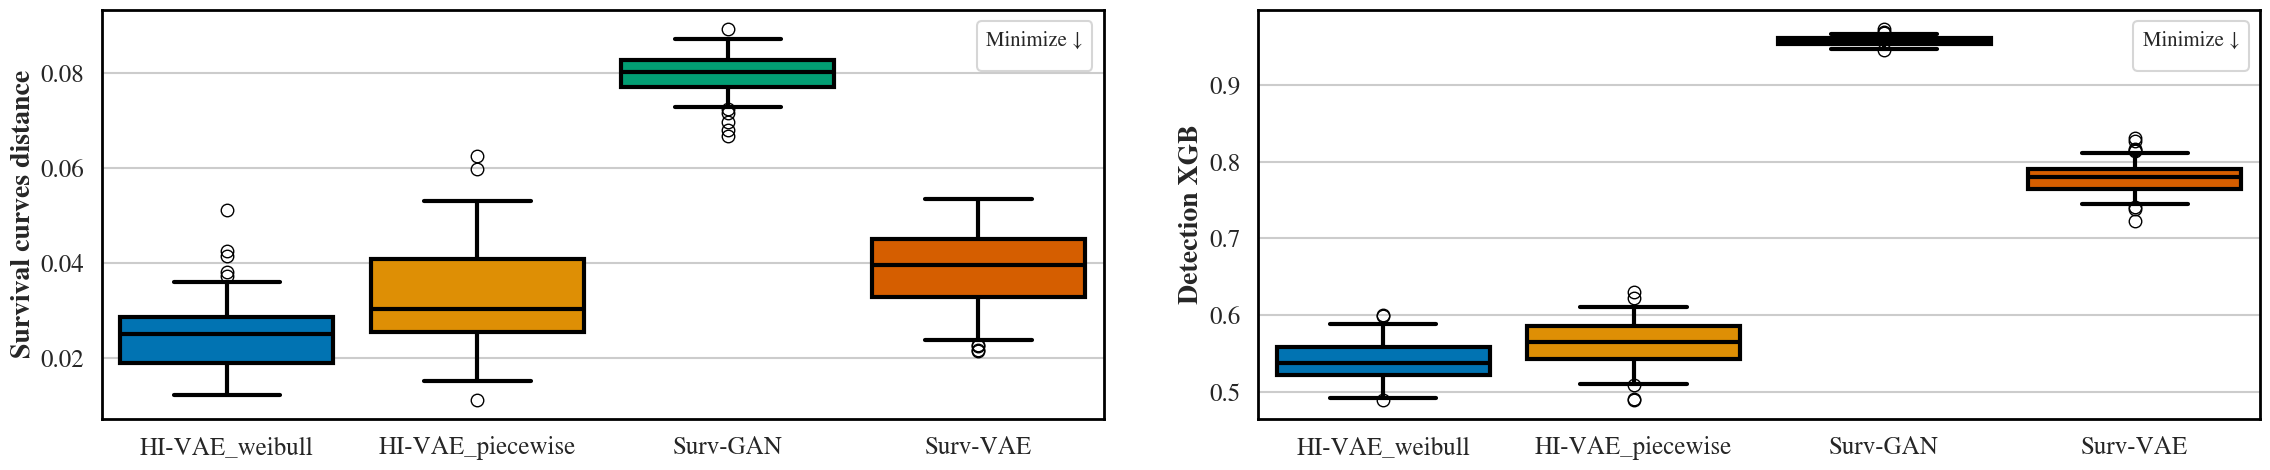

===================== General performance with default params: =====================


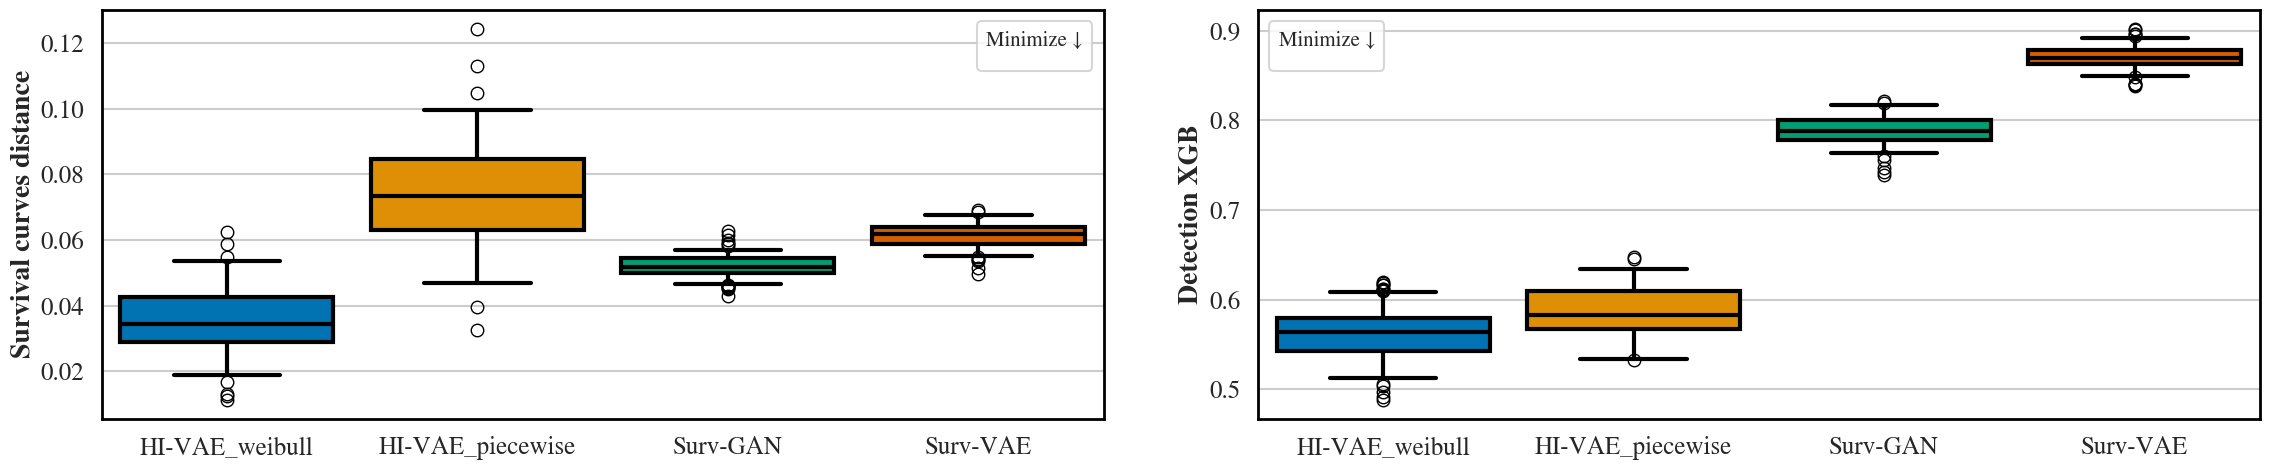

In [28]:
print("===================== General performance with best params survkm: =====================")
visualize_general_perf(general_scores_survkm_df, metrics=[['Survival curves distance', "min"], ['Detection XGB', "min"]])

print("===================== General performance with default params: =====================")
visualize_general_perf(general_scores_default_df, metrics=[['Survival curves distance', "min"], ['Detection XGB', "min"]])

#### 3.1.3. Privacy

===================== General performance with best params survkm: =====================


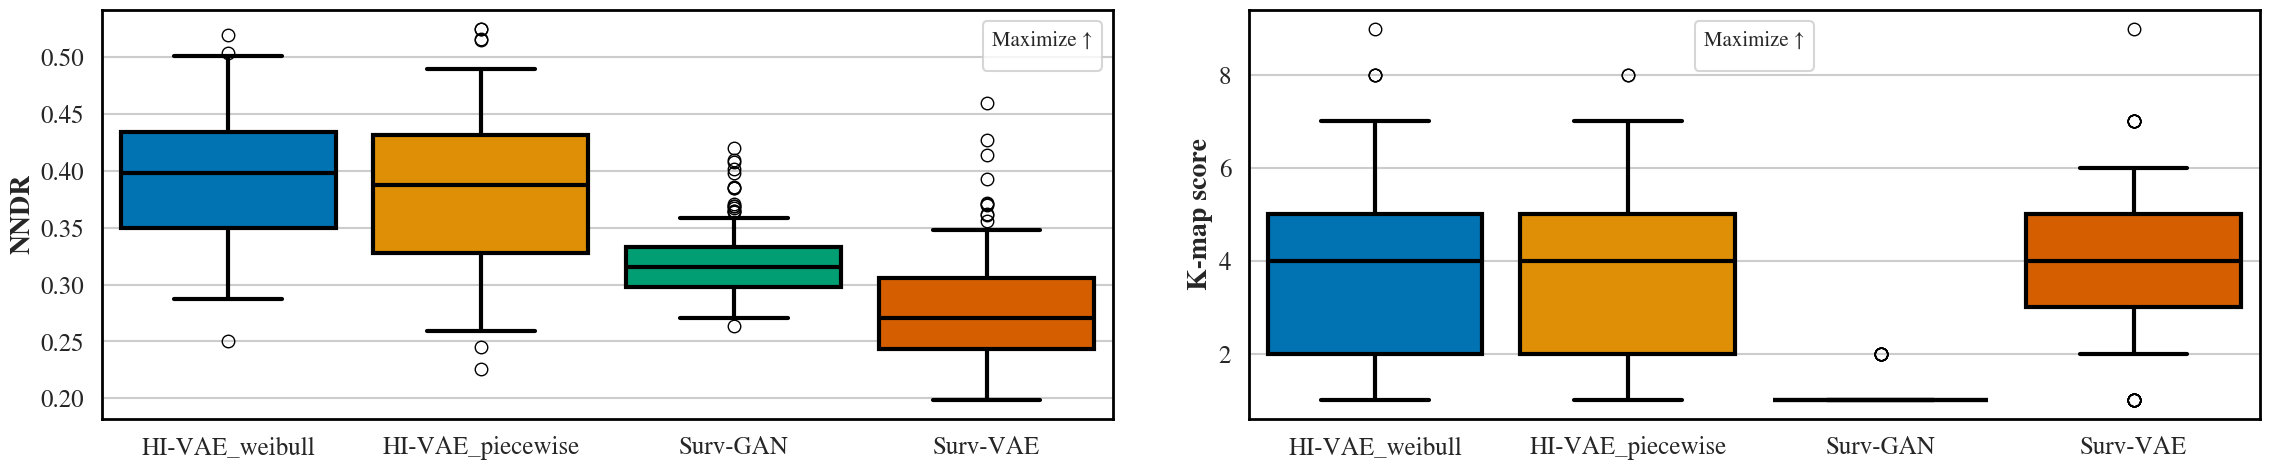

===================== General performance with default params: =====================


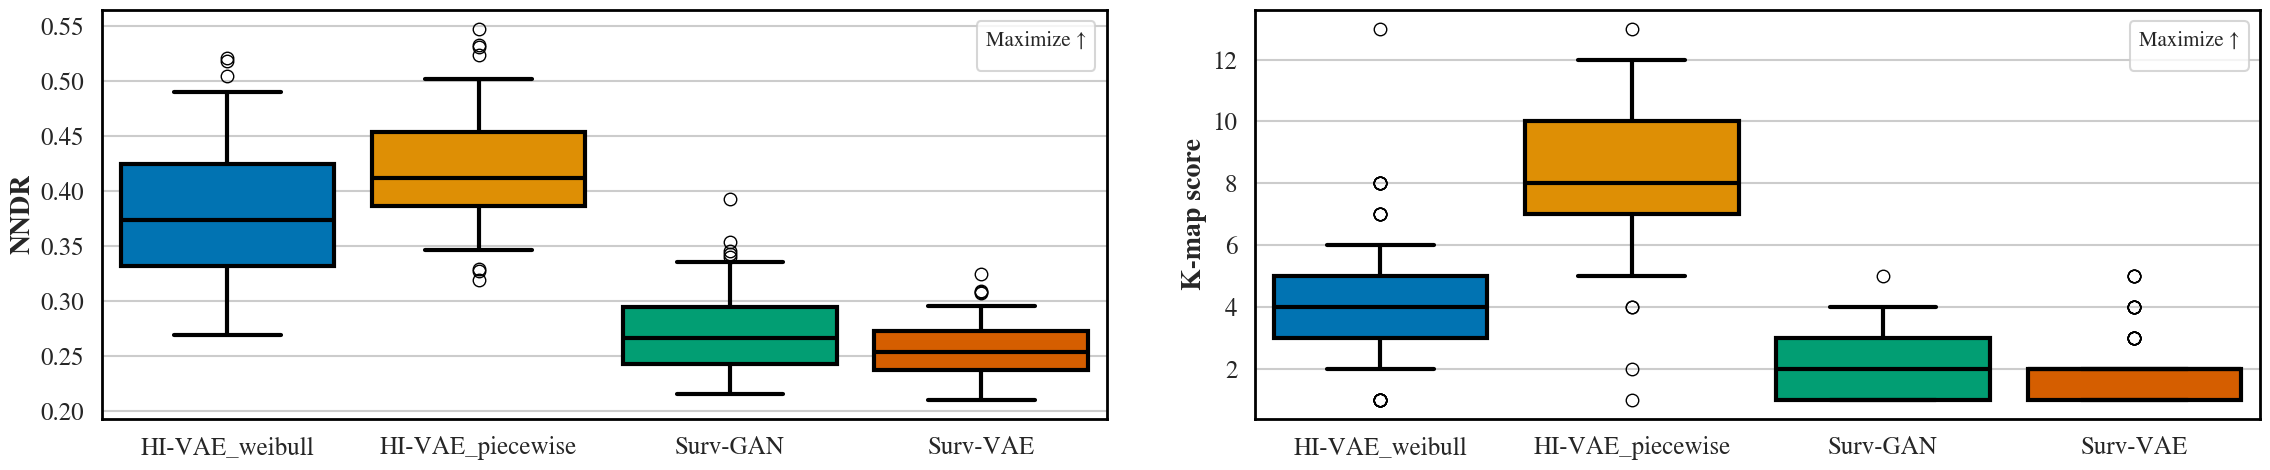

In [29]:
print("===================== General performance with best params survkm: =====================")
visualize_general_perf(general_scores_survkm_df, metrics=[['NNDR', "max"], ['K-map score', "max"]])

print("===================== General performance with default params: =====================")
visualize_general_perf(general_scores_default_df, metrics=[['NNDR', "max"], ['K-map score', "max"]])

#### Replicability metrics with best params

In [30]:
# choose the type of best parameters to use
df_syn_dict_best_params = df_syn_dict_best_params_survkm.copy()

In [31]:
from utils.metrics import replicability_ext
replicability_scores = []
for generator_name in generators_sel:
    replicability_scores.append(replicability_ext(df_init, df_syn_dict_best_params[generator_name], generator_name))
replicability_scores_df = pd.concat(replicability_scores, ignore_index=True)

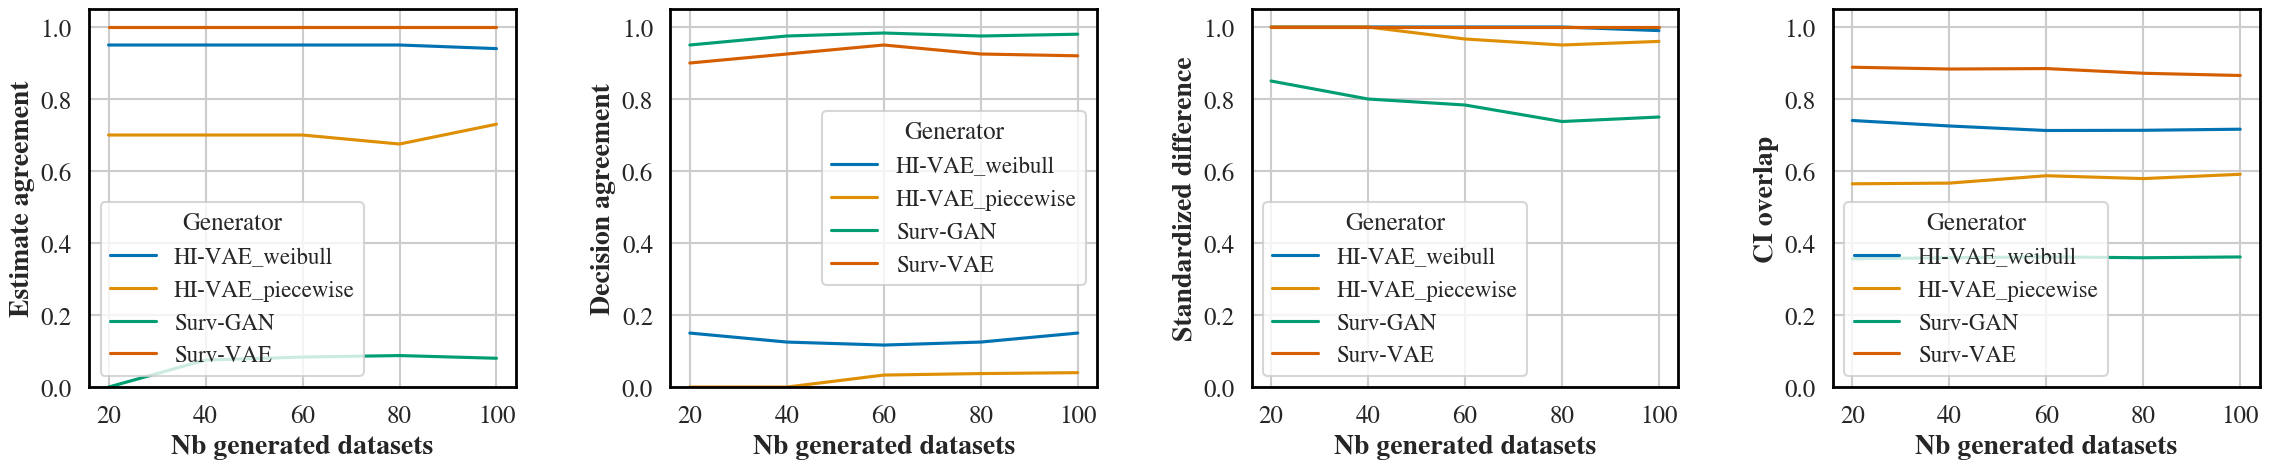

In [32]:
from utils.visualization import visualize_replicability_perf
visualize_replicability_perf(replicability_scores_df)

In [33]:
from utils.metrics import fit_cox_model
import numpy as np
columns = ['time', 'censor', 'treatment']
coef_init, _, ci_init, se_init = fit_cox_model(df_init, columns)
# Compute midpoints and widths
midpoints = [(ci_init[1] + ci_init[0]) / 2]
errors = [(ci_init[1] - ci_init[0]) / 2]
label = ["Init"]
colors = ['green', 'blue', 'orange', 'cyan']

colors_ = ['red']
for i , generator in enumerate(generators_sel):
    data_syn_ = df_syn_dict_best_params[generator]
    results = [fit_cox_model(data, columns) for data in data_syn_]
    coef_syn, _, _, se_syn = zip(*results)
    for n in range(10):
        coef_syn_, se_syn_ = np.array(coef_syn)[n][0], np.array(se_syn)[n][0]
        ci_syn = (coef_syn_ - 1.96 * se_syn_, coef_syn_ + 1.96 * se_syn_)
        midpoints.append((ci_syn[1] + ci_syn[0]) / 2)
        errors.append((ci_syn[1] - ci_syn[0]) / 2)
        label.append(generator + " " + str(n + 1))
        colors_.append(colors[i])

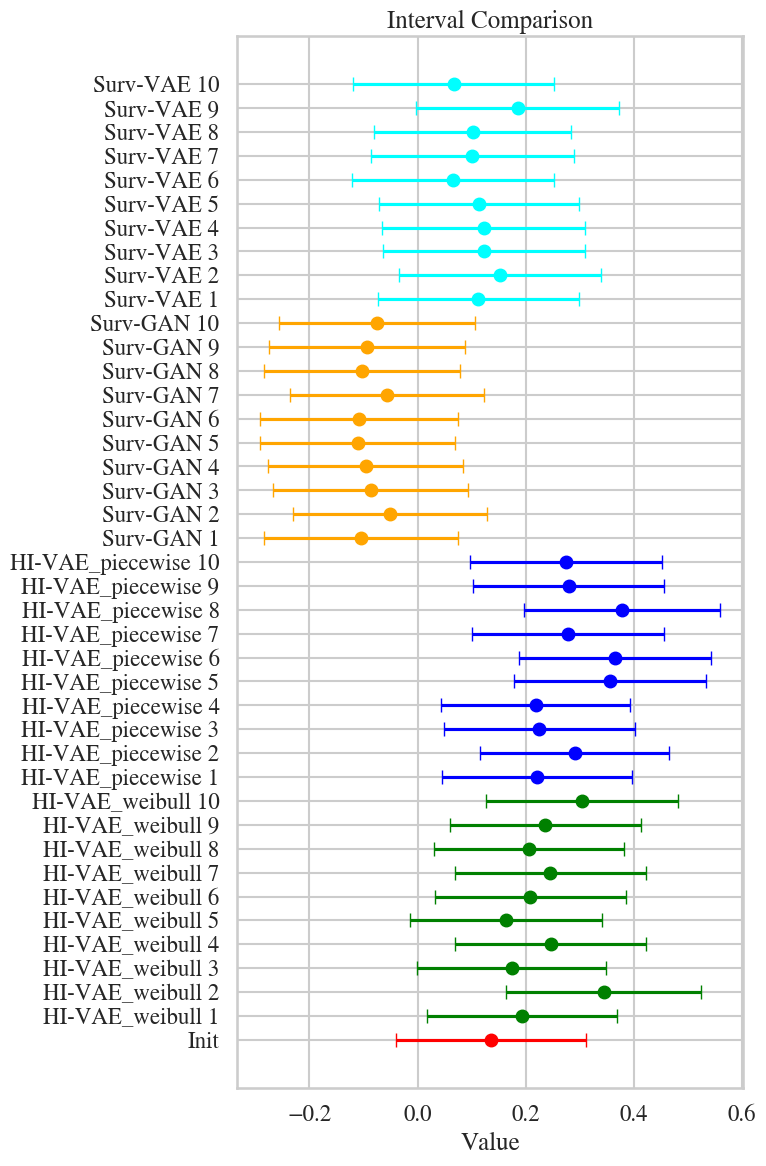

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 12))

# Plot as horizontal error bars
for i, (mid, err) in enumerate(zip(midpoints, errors)):
    ax.errorbar(x=mid, y=i, xerr=err, fmt='o', capsize=5, color=colors_[i])

plt.yticks(range(len(midpoints)), label)
plt.xlabel("Value")
plt.title("Interval Comparison")
plt.grid(True)
plt.tight_layout()
plt.show()